In [ ]:
import os
from constants import AUDIO_BLOCKS, COLOR_MAP

import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

import seaborn as sns

# Read data

In [219]:
result_dir = 'results'
pca_channel_breakdown = pd.read_csv(result_dir +'/PCA_wo_resampled.csv')
pca_c_spectral = pd.read_csv(result_dir +'/PCA_wo_resampled_C_spectral.csv')
#pca_d_spectral = pd.read_csv('PCA_C6_EEG_D_spectral.csv')

# A, B, C, D  -> 'ALL_SPECTRAL'
cebra_channel_breakdown = pd.read_csv(result_dir+'/CEBRA_wo_resampled.csv')
# C -> 'DELTA', 'THETA', 'ALPHA', 'BETA1', 'BETA2', 'GAMMA'
cebra_c_spectral = pd.read_csv(result_dir+'/CEBRA_wo_resampled_C_spectral.csv')
# ALL -> 'DELTA', 'THETA', 'ALPHA', 'BETA1', 'BETA2', 'GAMMA', 'ALL_SPECTRAL'
cebra_across_channels_spectral = pd.read_csv(result_dir+'/CEBRA_spectral_across_all_channels.csv')
cebra_1000iter_c_spectral = pd.read_csv(result_dir+'/CEBRA_1000iter_c_all_spectral.csv')

# Read rand index results
aduio_ari = pd.read_csv('../aduio_ari.csv')
print('mean:',aduio_ari['ari'].mean(), 'max:', aduio_ari['ari'].max(), 'min:', aduio_ari['ari'].min())

high_c = aduio_ari[aduio_ari['ari'] > aduio_ari['ari'].mean()]
low_c = aduio_ari[aduio_ari['ari'] <= aduio_ari['ari'].mean()]
print(len(high_c), len(low_c))

mean: 0.34038798576560975 max: 0.6732360097 min: 0.01374570447
18 23


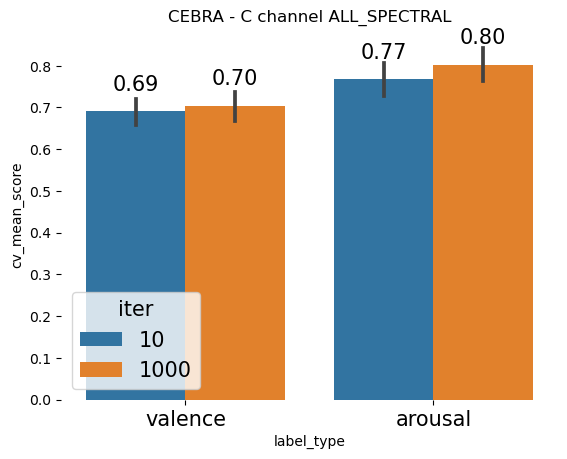

In [199]:
cebra_channel_breakdown['band'] = ['ALL_SPECTRAL']*len(cebra_channel_breakdown['channel'])
cebra_channel_breakdown['iter'] = [10]*len(cebra_channel_breakdown['channel'])

cebra_1000iter_c_spectral['band'] = cebra_1000iter_c_spectral['channel']
cebra_1000iter_c_spectral['iter'] = [1000]*len(cebra_1000iter_c_spectral['channel'])

result = pd.concat([cebra_channel_breakdown[cebra_channel_breakdown['channel'] == 'C'], cebra_1000iter_c_spectral], ignore_index=True)

d = result[result['label_type'] == 'valence']
ax = sns.barplot(result, x="label_type", y="cv_mean_score", hue='iter', width=0.8, units='subject')

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=12, size=15)
plt.setp(ax.get_xticklabels(), size=15)

ax.legend(fontsize=15, title='iter', title_fontsize=15)
ax.set_title(f'CEBRA - C channel ALL_SPECTRAL')
sns.despine(bottom = True, left = True)

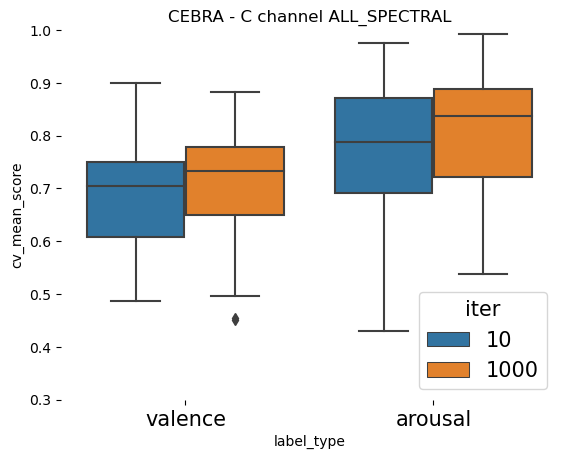

In [218]:
cebra_channel_breakdown['band'] = ['ALL_SPECTRAL']*len(cebra_channel_breakdown['channel'])
cebra_channel_breakdown['iter'] = [10]*len(cebra_channel_breakdown['channel'])

cebra_1000iter_c_spectral['band'] = cebra_1000iter_c_spectral['channel']
cebra_1000iter_c_spectral['iter'] = [1000]*len(cebra_1000iter_c_spectral['channel'])

result = pd.concat([cebra_channel_breakdown[cebra_channel_breakdown['channel'] == 'C'], cebra_1000iter_c_spectral], ignore_index=True)

ax = sns.boxplot(result, x="label_type", y="cv_mean_score", hue='iter', width=0.8)

for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=12, size=15)
plt.setp(ax.get_xticklabels(), size=15)

ax.legend(fontsize=15, title='iter', title_fontsize=15)
ax.set_title(f'CEBRA - C channel ALL_SPECTRAL')
ax.set(ylim=(0.3, 1))

sns.despine(bottom = True, left = True)

In [221]:
cebra_across_channels_spectral['band'] = cebra_across_channels_spectral['channel']
cebra_across_channels_spectral['channel_group'] = ['ALL']*len(cebra_across_channels_spectral['channel'])

cebra_c_spectral['band'] = cebra_c_spectral['channel']
cebra_c_spectral['channel_group'] = ['C']*len(cebra_c_spectral['channel'])

cebra_channel_breakdown['channel_group'] = cebra_channel_breakdown['channel']
cebra_channel_breakdown['band'] = ['ALL_SPECTRAL']*len(cebra_channel_breakdown['channel'])

result = pd.concat([cebra_across_channels_spectral, cebra_channel_breakdown, cebra_c_spectral], ignore_index=True)
result.head()

,Unnamed: 0,subject,channel,label_type,cv_mean_score,band,channel_group
0,0,2040,DELTA,valence,0.650000,DELTA,ALL
1,1,2040,THETA,valence,0.620833,THETA,ALL
2,2,2040,ALPHA,valence,0.650000,ALPHA,ALL
3,3,2040,BETA1,valence,0.612500,BETA1,ALL
4,4,2040,BETA2,valence,0.625000,BETA2,ALL


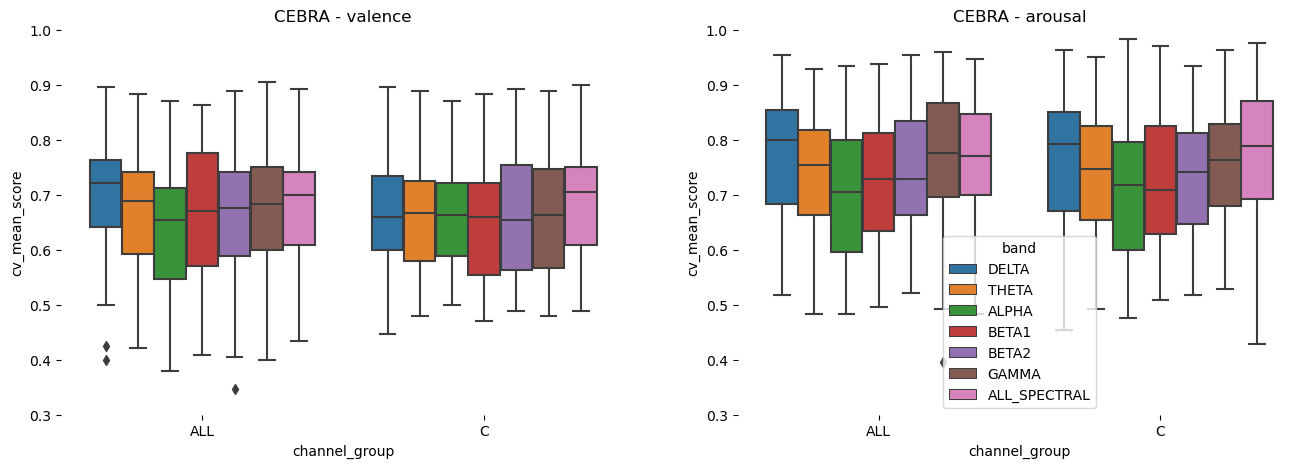

In [222]:
n_row, n_col = (1,2) #(4, 8)
fig, axes = plt.subplots(
    nrows=n_row,
    sharey=False,
    ncols=n_col,
    figsize=(n_col * 8, n_row * 5),
)

for idx, label_type in enumerate(['valence', 'arousal']):
    d = result[(result['label_type'] == label_type) & (result['channel_group'].isin(['ALL', 'C']))]
    medians = d.groupby(['channel_group', 'band'])['cv_mean_score'].median()
    #ax = sns.barplot(d, x="channel_group", y="cv_mean_score", hue='band', width=0.8, units='subject', ax=axes.flat[idx])
    ax = sns.boxplot(d, x="channel_group", y="cv_mean_score", hue='band',  ax=axes.flat[idx])

    # for i in ax.containers:
    #     ax.bar_label(i, fmt='%.2f', padding=13)  
    
    ax.get_legend().set_visible(idx == 1)
    ax.set_title(f'CEBRA - {label_type}')
    ax.set(ylim=(0.3, 1))
sns.despine(bottom = True, left = True)

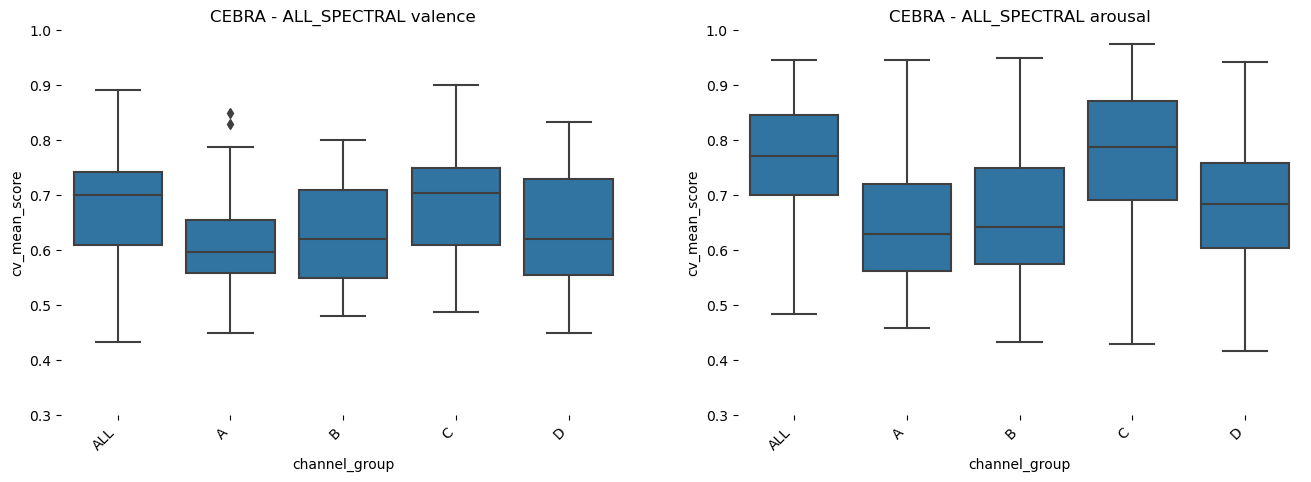

In [223]:
n_row, n_col = (1,2) #(4, 8)
fig, axes = plt.subplots(
    nrows=n_row,
    sharey=False,
    ncols=n_col,
    figsize=(n_col * 8, n_row * 5),
)

for idx, label_type in enumerate(['valence', 'arousal']):
    d = result[(result['label_type'] == label_type) & (result['band'].isin(['ALL_SPECTRAL']))]
    #ax = sns.barplot(d, x="channel_group", y="cv_mean_score", hue='band', width=0.8, units='subject', ax=axes.flat[idx])
    ax = sns.boxplot(d, x="channel_group", y="cv_mean_score", hue='band',  ax=axes.flat[idx])
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=13)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.get_legend().set_visible(False)
    ax.set_title(f'CEBRA - ALL_SPECTRAL {label_type}')
    ax.set(ylim=(0.3, 1))
sns.despine(bottom = True, left = True)    

In [ ]:
# Read labels pkl file
with open('./data/behavioral_labels.pkl', 'rb') as fp:
    behavioral_labels = pickle.load(fp)

data_dir = "../CleandDataV2/"
attention_labels = {}
i = 0
for d in os.listdir(data_dir):
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue
    
    attention_labels[d] = behavioral_labels['attention_labels'][i]
    i += 1

# Embedding Visualization

In [158]:
from resample.resample import get_consecutive_validation_indexes
from constants import AUDIO_BLOCKS

num_slice_per_trial = 5
n_step_trial = 3
val_indexes = [
    get_consecutive_validation_indexes(
        260, len(AUDIO_BLOCKS), num_slice_per_trial, i, n_step_trial
    )
    for i in range(1, 13, n_step_trial)
]
print(len(val_indexes), val_indexes)

subjects_ordered_by_c = list(high_c['subject']) + list(low_c['subject'])

4 [[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229], [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 180, 181, 182, 183, 184, 185, 186, 

In [162]:
from model.embedding import tsne_visualization, umap_visualization


def _get_max_score_index_corr(embeddings, embedding_labels):
    abs_corr = []
    for idx in range(embeddings.shape[-1]):
        corr = np.corrcoef(embeddings[:, idx], embedding_labels)[0, 1]
        abs_corr.append(np.abs(corr))

    return np.array(abs_corr).argmax(axis=0)


def _get_best_embedding_idx(subject_to_embedding, label_types, subject_list: list = []):
    best_embedding_idx = {l: [] for l in label_types}
    val_embeddings_idx = {l: [] for l in label_types}
    for l in label_types:
        for s in subject_list:
            s  = str(s)
            (
                _,
                _,
                (embeddings, val_embeddings),
                (embedding_labels, val_embedding_labels),
            ) = subject_to_embedding[s][l][0]

            max_score_index = _get_max_score_index_corr(embeddings, embedding_labels)
            best_embedding_idx[l].append(max_score_index)

            max_score_index = _get_max_score_index_corr(
                val_embeddings, val_embedding_labels
            )
            val_embeddings_idx[l].append(max_score_index)

    return best_embedding_idx, val_embeddings_idx


def _plot_embedding_corr(
    subject_to_embedding, label_best_embedding_idx, high_c, subject_list: list = [], is_val: bool=False
):
    colorMap = {"valence": "#94b325", "arousal": "#595eeb", "valence-arousal": 'olive'}

    for label_type, best_embedding_idx in label_best_embedding_idx.items():
        n_row, n_col = (5, 8)
        f, axarr = plt.subplots(
            n_row, n_col, figsize=(3 * n_col, 3 * n_row), sharey=True
        )
        for idx, ax in enumerate(axarr.flat):
            s = str(subject_list[idx])
            l = f"L{best_embedding_idx[idx]}"
            (
                name,
                _,
                (train_embeddings, val_embeddings),
                (train_embedding_labels, val_embedding_labels),
            ) = subject_to_embedding[s][label_type][0]
            
            embeddings = val_embeddings if is_val else train_embeddings
            embedding_labels = val_embedding_labels if is_val else train_embedding_labels

            result = pd.DataFrame(
                {l: embeddings[:, best_embedding_idx[idx]], "labels": embedding_labels}
            )
            sns.regplot(
                data=result,
                ci=99,
                x=l,
                y="labels",
                color=colorMap[label_type],
                line_kws=dict(color="r"),
                ax=ax,
            )
            corr = np.corrcoef(result[l], embedding_labels)[0, 1]
            ax.text(
                0.1,
                0.95,
                "$r$ = {:.3f}".format(corr),
                horizontalalignment="left",
                verticalalignment="center",
                color="red",
                fontweight="heavy",
                transform=ax.transAxes,
                size=12,
            )
            font_color = 'red' if int(s) in list(high_c['subject']) else 'black'  
            ax.set_title(s + name, fontsize=8, color=font_color)            
            ax.set(ylim=(0, 1))
        f.tight_layout(pad=1.8)

def _get_projected_embeddings(
    subject_to_embedding, visualization_func, subject_to_shuffled_indexes, label_types: list = []
):
    # Compute the projections
    subject_list = list(subject_to_embedding.keys())
    block_name_conditions = np.repeat(AUDIO_BLOCKS, 260 / len(AUDIO_BLOCKS))

    projected_val_embeddings = {l: [] for l in label_types}
    projected_embeddings = {l: [] for l in label_types}
    for l in label_types:
        for s in subject_list:
            (
                _,
                max_idx,
                (embeddings, val_embeddings),
                (embedding_labels, val_embedding_labels),
            ) = subject_to_embedding[s][l][0]
            
            if len(subject_to_shuffled_indexes) > 0:
                shuffled_train_indexes, shuffled_val_indexes = subject_to_shuffled_indexes['2001']['valence-arousal']
            else:
                shuffled_train_indexes, shuffled_val_indexes = subject_to_shuffled_indexes['shuffled_indexes']

            proj_2d = visualization_func(val_embeddings)
            proj_2d_df = pd.DataFrame(
                {
                    "dim 1": proj_2d[:, 0],
                    "dim 2": proj_2d[:, 1],
                    "block": block_name_conditions[shuffled_val_indexes[max_idx]],
                    "score": val_embedding_labels,
                }
            )
            projected_val_embeddings[l].append(proj_2d_df)

            train_indexes = list(set(range(260)) - set(val_indexes[max_idx]))
            proj_2d = visualization_func(embeddings)
            proj_2d_df = pd.DataFrame(
                {
                    "dim 1": proj_2d[:, 0],
                    "dim 2": proj_2d[:, 1],
                    "block": block_name_conditions[shuffled_train_indexes[max_idx]],
                    "score": embedding_labels,
                }
            )
            projected_embeddings[l].append(proj_2d_df)
    return projected_embeddings, projected_val_embeddings


method = "CEBRA"

### Two classification

In [163]:
# Read dictionary pkl file
with open('./results/models/CEBRA_1000iter_c_all_spectral_embeddings.pkl', 'rb') as fp:
    subject_to_embedding = pickle.load(fp)

with open('./results/models/no_shuffled_test_100iter_valence_arsoual_c_all_spectral_indexes.pkl', 'rb') as fp:
    shuffled_indexes = pickle.load(fp)  

# with open('./results/models/shuffled_indexes.pkl', 'rb') as fp:
#     shuffled_indexes = pickle.load(fp)
           
#subject_to_embedding = { s: subject_to_embedding[s] for s in ['2001', '2005', '2031']}
print(len(subject_to_embedding))

label_types = ["valence", "arousal"]
subject_list = list(subject_to_embedding.keys())
projected_embeddings, projected_val_embeddings = _get_projected_embeddings(subject_to_embedding, tsne_visualization, shuffled_indexes, label_types)

41


In [ ]:
label_types = ["valence", "arousal"]
best_embedding_idx, val_embeddings_idx = _get_best_embedding_idx(subject_to_embedding, label_types, subjects_ordered_by_c)
_plot_embedding_corr(subject_to_embedding, val_embeddings_idx, high_c, subjects_ordered_by_c, True)

### Four classification

In [31]:
# Read dictionary pkl file
with open('./results/models/no_shuffled_test_100iter_valence_arsoual_c_all_spectral_embeddings.pkl', 'rb') as fp:
    va_subject_to_embedding = pickle.load(fp)

with open('./results/models/no_shuffled_test_100iter_valence_arsoual_c_all_spectral_indexes.pkl', 'rb') as fp:
    shuffled_indexes = pickle.load(fp)    

print(len(va_subject_to_embedding))

label_types = ["valence-arousal"]
subject_list = list(va_subject_to_embedding.keys())
va_projected_embeddings, va_projected_val_embeddings = _get_projected_embeddings(va_subject_to_embedding, tsne_visualization, shuffled_indexes, label_types)

3


/var/folders/6y/khb9drcn0p373bwf72szrzvm0000gn/T/ipykernel_12761/3648349868.py:79: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=1.8)
/var/folders/6y/khb9drcn0p373bwf72szrzvm0000gn/T/ipykernel_12761/3648349868.py:79: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=1.8)


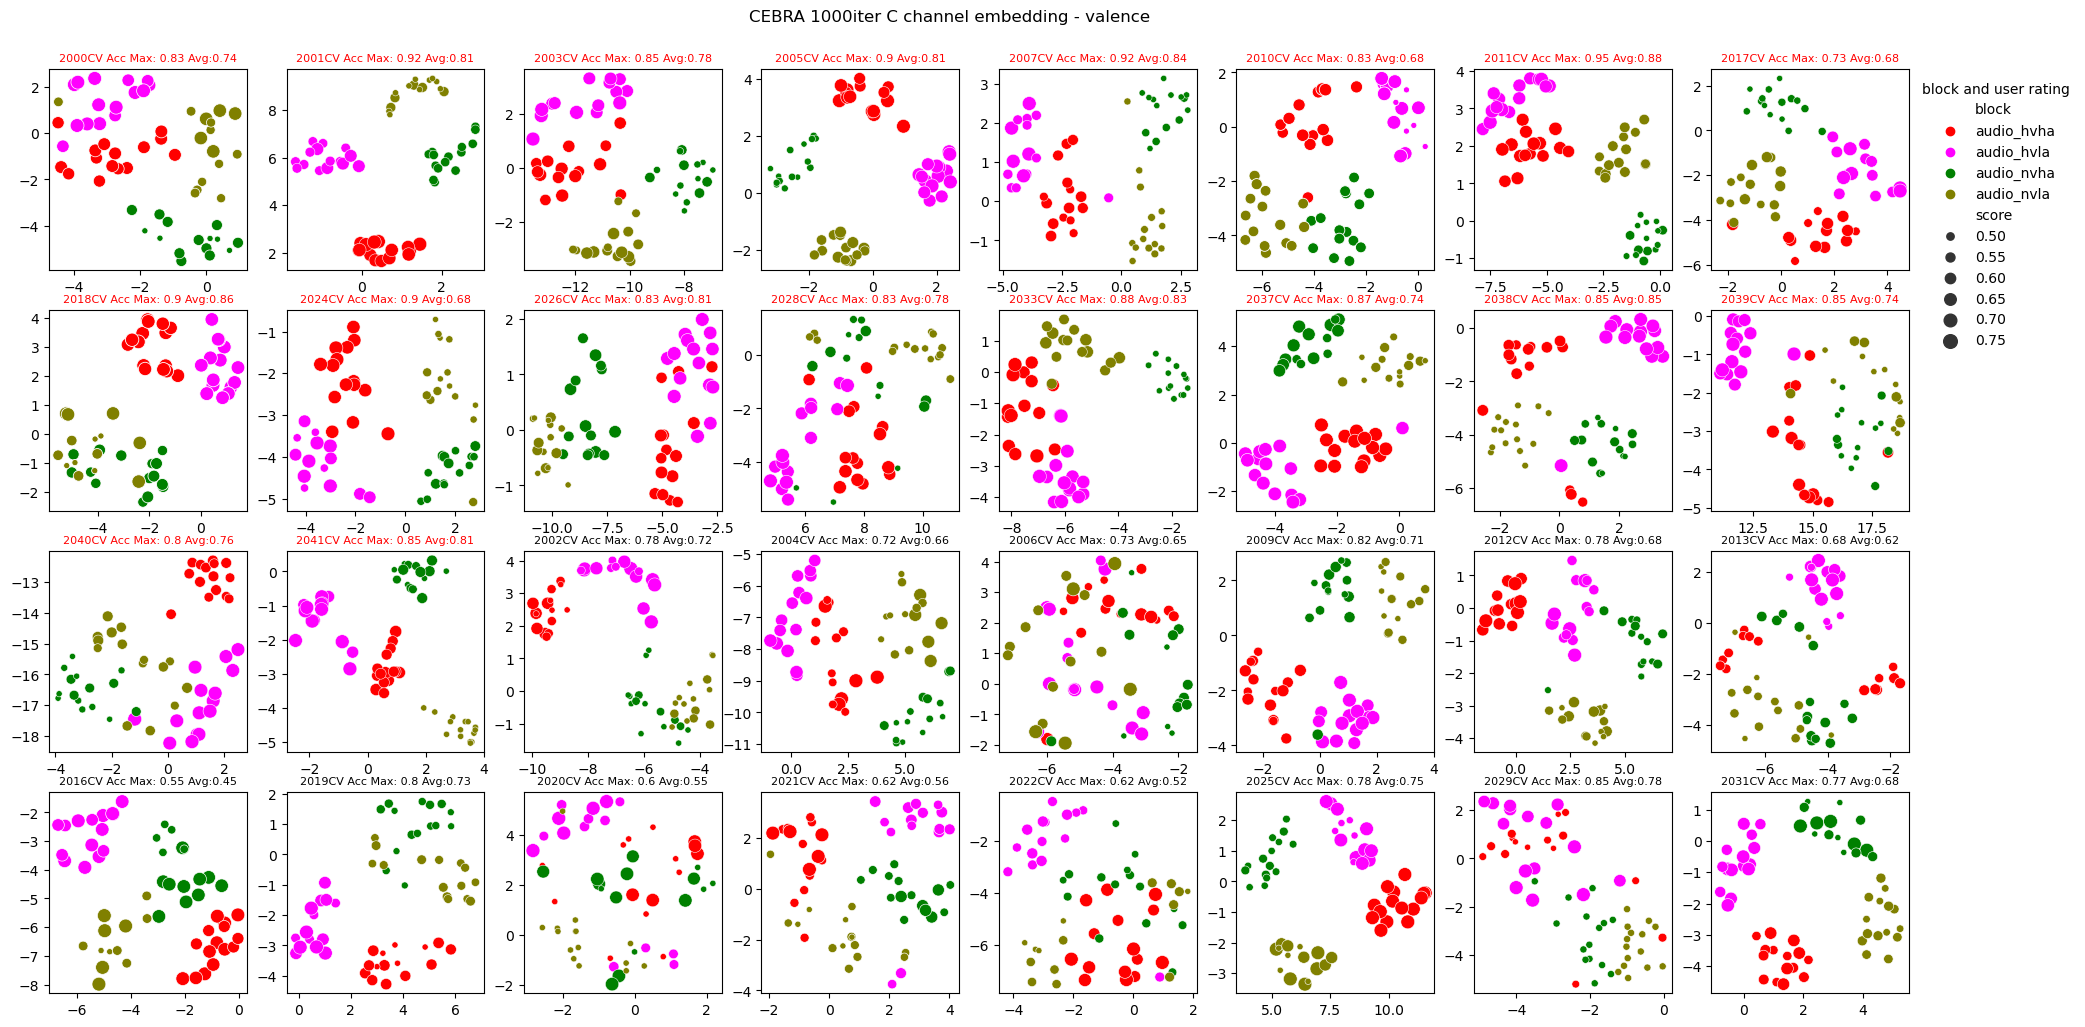

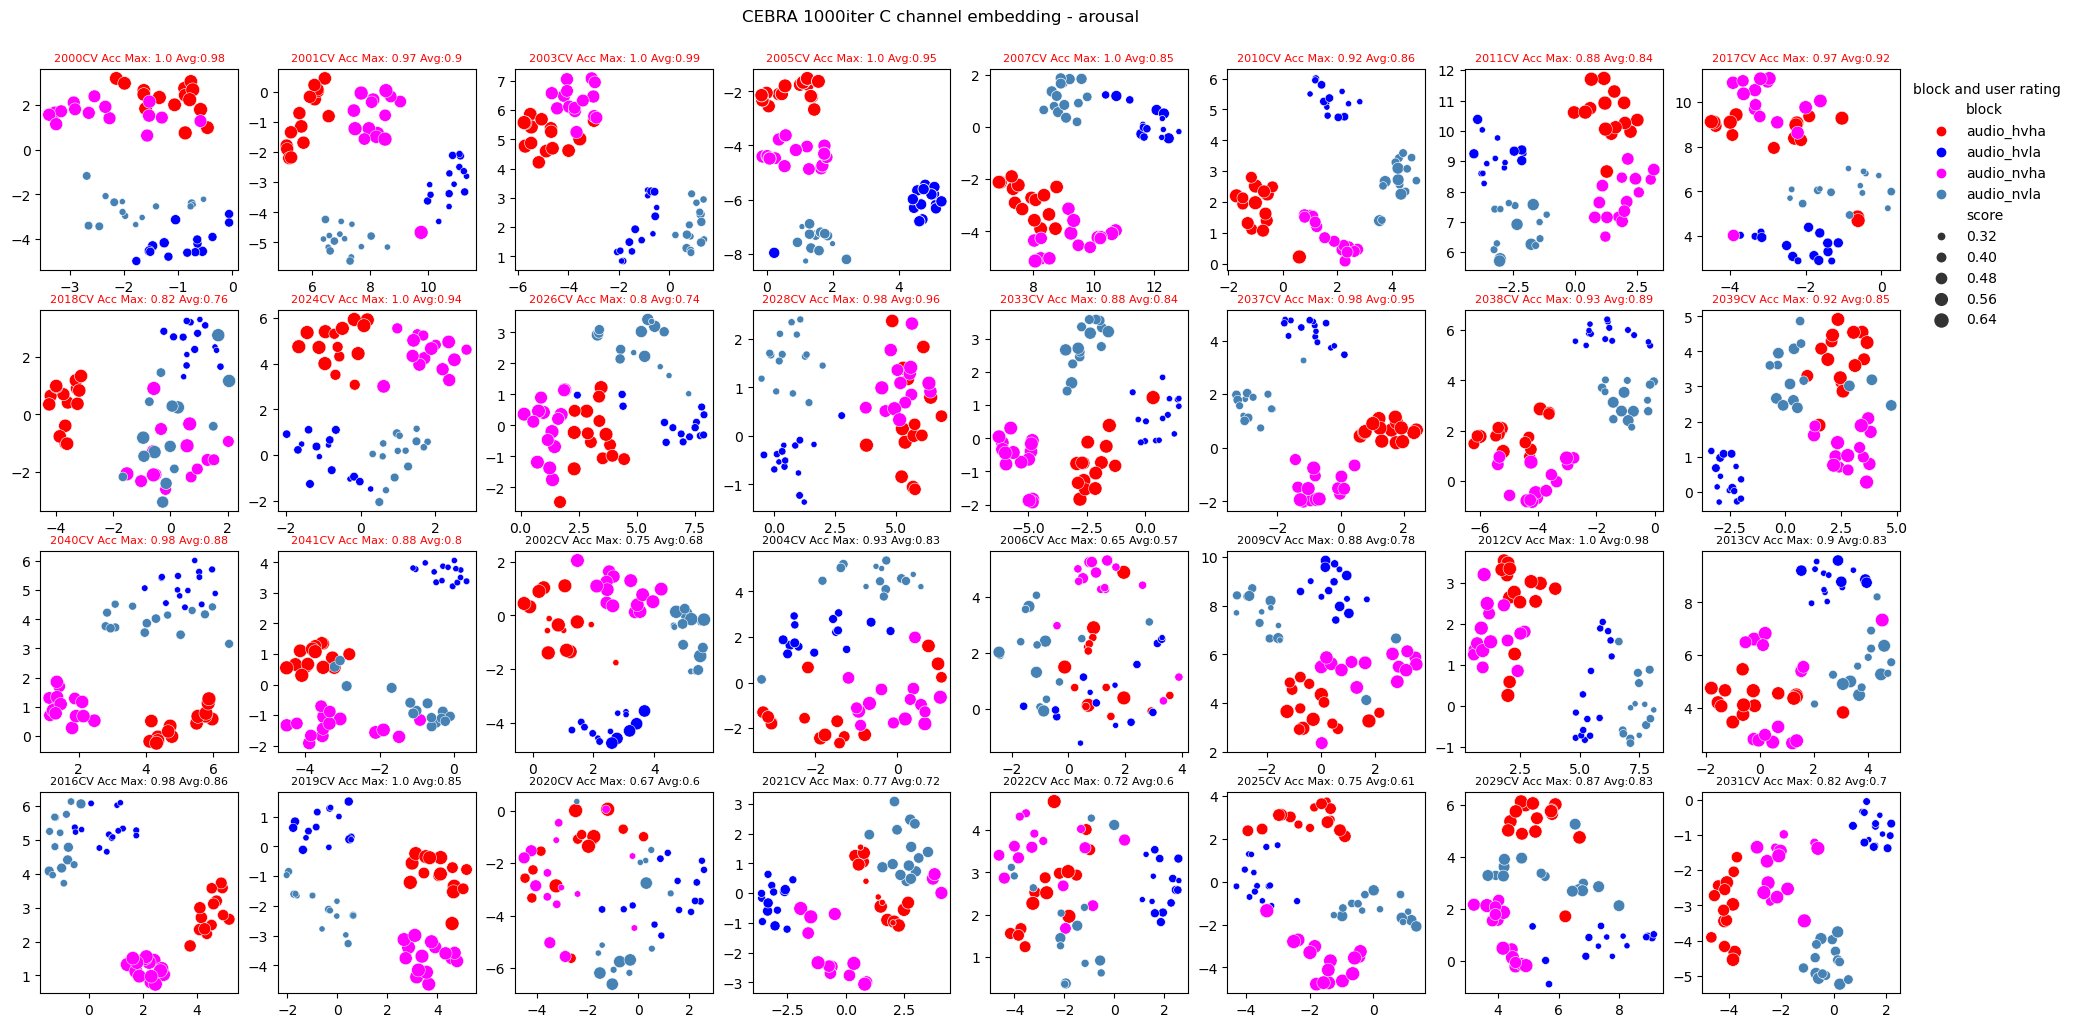

In [198]:
method = "CEBRA"

A_COLOR_MAP = {
    "audio_hvha": "red",
    "audio_nvha": "magenta",
    "audio_hvla": "blue",
    "audio_nvla": "steelblue",
}

to_be_visualized_embed = projected_val_embeddings
to_be_visualized_subjects = subject_to_embedding
is_four_classification = len(list(to_be_visualized_embed.keys())) == 1
condition_list = list(COLOR_MAP.keys()) # for four classification
markers = {"audio_hvha": 'X', "audio_nvha": '*', "audio_hvla": '^', "audio_nvla": 'P'}

for l in list(to_be_visualized_embed.keys()):
    n_row, n_col = (4, 8)
    fig, axes = plt.subplots(
        nrows=n_row,
        sharey=False,
        ncols=n_col,
        figsize=(n_col * 3, n_row * 3),
    )

    for i, ax in enumerate(axes.flat):
        s = str(subjects_ordered_by_c[i])
        s_idx = subject_list.index(s)
        (name, _, _, _) = to_be_visualized_subjects[s][l][0]

        proj_2d_df = to_be_visualized_embed[l][s_idx]
        if is_four_classification:
            show_legend = "auto" if i == 7 else False
            user_rating_categories = [condition_list[sc] for sc in proj_2d_df['score']]
            g1 = sns.scatterplot(
                data=proj_2d_df,
                x="dim 1",
                y="dim 2",
                hue="block",
                style=user_rating_categories,
                style_order=condition_list,
                palette=COLOR_MAP if 'valence'in l else A_COLOR_MAP,
                ax=ax,
                s=100,
                markers=markers,
                legend=show_legend,
            )            
        else:
            show_legend = "auto" if i == 0 else False    
            g1 = sns.scatterplot(
                data=proj_2d_df,
                x="dim 1",
                y="dim 2",
                hue="block", #"block",
                size="score",
                palette=COLOR_MAP if 'valence'in l else A_COLOR_MAP,
                sizes=(20, 100),
                ax=ax,
                legend=show_legend,
            )
        g1.set(xlabel=None, ylabel=None)

        font_color = 'red' if int(s) in list(high_c['subject']) else 'black'  
        ax.set_title(s + name, fontsize=8, color=font_color)
        
        if show_legend == "auto":
            sns.move_legend(
                ax,
                "upper left", bbox_to_anchor=(n_col+1.4, 1),
                ncol=1,
                title='block and user rating',
                markerscale=1,
                frameon=False,
            )

    fig.suptitle(
        f"{method} 1000iter C channel embedding - {l}",
        y=0.93
    )
    fig.tight_layout(pad=1.8)

In [ ]:
for label_type in label_types:
    n_row, n_col = (2, 8)
    fig, axes = plt.subplots(
        nrows=n_row,
        sharey=False,
        ncols=n_col,
        figsize=(n_col * 3, n_row * 4),
    )

    for idx, ax in enumerate(axes.flat):
        s = subject_list[idx]
        name, _, (embeddings, val_embeddings), (embedding_labels, val_embedding_labels) = subject_to_embedding[s][label_type][0]
        ax.set_title(s+name, fontsize=10)

        proj_2d = tsne_visualization(val_embeddings)
        proj_2d_df = pd.DataFrame(
            {
                "dim 1": proj_2d[:, 0],
                "dim 2": proj_2d[:, 1],
                "score": val_embedding_labels,
            }
        )
        show_legend = 'auto' if idx == 0 else False
        y = sns.scatterplot(data=proj_2d_df, x="dim 1", y="dim 2", hue="score", ax=ax, legend=show_legend)
        y.set(xlabel=None, ylabel=None)

        if show_legend == 'auto':
            sns.move_legend(ax, "lower center", bbox_to_anchor=(1, 1.1), ncol=6, title=None, frameon=False)         
        
        # Use matplot
        # y = ax.scatter(
        #     proj_2d[:, 0],
        #     proj_2d[:, 1],
        #     cmap="cool",
        #     c=val_embedding_labels,
        #     s=5,
        #     vmin=0,
        #     vmax=1,
        # )

        # if idx % n_col == 7:
        #     yc = plt.colorbar(y, fraction=0.03, pad=0.05, ticks=np.linspace(0, 1, 5))
        #     yc.ax.tick_params(labelsize=10)
        #     yc.ax.set_title("score", fontsize=10)

    fig.suptitle(
        f"{tsne_visualization.__name__}:{method} C channel val embedding - {label_type}"
    )
    #fig.tight_layout(pad=1.8)

# Spectral rank order

In [ ]:
cebra_c_spectral_va = pd.read_csv('results/mean_CEBRA_valence_arousal_C_spectral.csv')
pca_c_spectral_va = pd.read_csv('results/mean_PCA_valence_arousal_C_spectral.csv')
pca_c_spectral_va.head()

In [ ]:
filtered_data = cebra_c_spectral_va[cebra_c_spectral_va['subject'].isin(list(low_c['subject']))]
subject_to_rank = {int(s): 0 for s in list(filtered_data['subject'].unique())}
for c in filtered_data["channel"].unique():
    if c == 'ALL_SPECTRAL':
        continue
    
    ranked_s = list(
        filtered_data[filtered_data["channel"] == c].sort_values(
            "cv_mean_score", ascending=False
        )["subject"]
    )
    for idx, s in enumerate(ranked_s):
        subject_to_rank[s] += idx


In [ ]:
num_bands = len(cebra_c_spectral_va["channel"].unique())-1
avg_rank = np.array(list(subject_to_rank.values()))/num_bands
ax = sns.histplot(avg_rank, bins=40)
ax.set_title('low consistency - average rank order across C channel bands for each subjects')

In [ ]:
top_results = {'channel': [], 'cv_mean_score': [], 'subject': []}
for c in filtered_data['channel'].unique():
    if c == 'ALL_SPECTRAL':
        continue

    s = filtered_data[filtered_data['channel'] == c].sort_values('cv_mean_score', ascending=False).head(5)
    for k in top_results.keys():
        top_results[k].extend(s[k])

top_results = pd.DataFrame(top_results)
b = sns.barplot(top_results, x="subject", y="cv_mean_score", hue="channel")
b.set_title('top 5 score from each band')
sns.move_legend(b, "upper right", bbox_to_anchor=(1.3, 1))

In [ ]:
top_results = {'channel': [], 'cv_mean_score': [], 'subject': []}
for c in pca_c_spectral_va['channel'].unique():
    if c == 'ALL_SPECTRAL':
        continue

    s = cebra_c_spectral_va[pca_c_spectral_va['channel'] == c].sort_values('cv_mean_score', ascending=False).head(5)
    for k in top_results.keys():
        top_results[k].extend(s[k])

top_results = pd.DataFrame(top_results)
b = sns.barplot(top_results, x="subject", y="cv_mean_score", hue="channel")
b.set_title('top 5 score from each band')
sns.move_legend(b, "upper right", bbox_to_anchor=(1.3, 1))

# Compare across spectral features

In [ ]:
filtered_channel = 'C'
cebra_result = pd.concat(
    [
        cebra_c_spectral,
        cebra_channel_breakdown[cebra_channel_breakdown["channel"].isin([filtered_channel])],
    ]
)
pca_result = pd.concat(
    [
        pca_c_spectral,
        pca_channel_breakdown[pca_channel_breakdown["channel"].isin([filtered_channel])],
    ]
)

fig, axes = plt.subplots(
    nrows=1,
    sharey=True,
    ncols=2,
    figsize=(2 * 5, 1 * 5),
)
for idx, (method, result) in enumerate([("CEBRA", cebra_result), ("PCA", pca_result)]):
    title = f"EEG {filtered_channel} channel - {method}"  #
    g = sns.swarmplot(
        data=result,
        x="label_type",
        y="cv_mean_score",
        hue="channel",
        alpha=0.6,
        dodge=True,
        legend=False,
        size=3,
        ax=axes.flat[idx],
    )
    g.set_ylim((0.35, 1))
    
    df_means = (
        result.groupby(["label_type", "channel"])["cv_mean_score"]
        .agg("mean")
        .reset_index()
    )
    pp = sns.pointplot(
        x="label_type",
        y="cv_mean_score",
        data=df_means,
        hue="channel",
        dodge=0.6,
        linestyles="",
        errorbar=None,
        scale=2,
        markers="_",
        ax=axes.flat[idx],
        hue_order=[
            "DELTA",
            "THETA",
            "ALPHA",
            "BETA1",
            "BETA2",
            "GAMMA",
            filtered_channel,
        ],
        order=["valence", "arousal"],
    )

    axes.flat[idx].get_legend().set_visible((idx == 1))
    if idx == 1:
        axes.flat[idx].get_legend().set_title('feature')
        sns.move_legend(pp, "upper right", bbox_to_anchor=(1.5, 1))

    g.set_title(title)

# Compare across channels

In [ ]:
cebra_result = pd.concat(
    [
        cebra_channel_breakdown,
        cebra_all_channel,
    ]
)
pca_result = pd.concat(
    [
        pca_channel_breakdown,
        pca_all_channel,
    ]
)

fig, axes = plt.subplots(
    nrows=1,
    sharey=True,
    ncols=2,
    figsize=(2 * 5, 1 * 5),
)
for idx, (method, result) in enumerate([("CEBRA", cebra_result), ("PCA", pca_result)]):
    title = f"EEG channel - {method}"  #
    g = sns.swarmplot(
        data=result,
        x="label_type",
        y="cv_mean_score",
        hue="channel",
        alpha=0.6,
        dodge=True,
        legend=False,
        ax=axes.flat[idx],
    )
    g.set_ylim((0.35, 1))
    
    df_means = (
        result.groupby(["label_type", "channel"])["cv_mean_score"]
        .agg("mean")
        .reset_index()
    )
    pp = sns.pointplot(
        x="label_type",
        y="cv_mean_score",
        data=df_means,
        hue="channel",
        dodge=0.6,
        linestyles="",
        errorbar=None,
        scale=2.5,
        markers="_",
        ax=axes.flat[idx],
        hue_order=["A", "B", "C", "D", "ALL"],
        order=["valence", "arousal"],
    )
    axes.flat[idx].get_legend().set_visible((idx == 1))
    if idx == 1:
        sns.move_legend(pp, "upper right", bbox_to_anchor=(1.3, 1))

    g.set_title(title)

# Consistency home - in lab breakdown

In [ ]:
fig, axes = plt.subplots(
    nrows=1,
    sharey=True,
    ncols=2,
    figsize=(2 * 5, 1 * 5),
)
for idx, (method, result) in enumerate(
    [("CEBRA", cebra_channel_breakdown), ("PCA", pca_channel_breakdown)]
):
    channel_mask = result["channel"].isin(["C"])
    result = result[channel_mask]
    result["subject"] = result["subject"].astype(int)

    consistency_level = []
    for s in list(result["subject"]):
        level = "high" if s in set(high_c["subject"]) else "low"
        consistency_level.append(level)

    result["consistency_level"] = consistency_level

    title = f"EEG C channel - {method}"  #
    g = sns.swarmplot(
        data=result,
        x="label_type",
        y="cv_mean_score",
        hue="consistency_level",
        alpha=0.6,
        dodge=True,
        legend=False,
        ax=axes.flat[idx],
    )
    g.set_ylim((0.35, 1))

    df_means = (
        result.groupby(["label_type", "consistency_level"])["cv_mean_score"]
        .agg("mean")
        .reset_index()
    )
    pp = sns.pointplot(
        x="label_type",
        y="cv_mean_score",
        data=df_means,
        hue="consistency_level",
        dodge=0.4,
        linestyles="",
        errorbar=None,
        scale=2.5,
        markers="_",
        ax=axes.flat[idx],
        hue_order=["high", "low"],
        order=["valence", "arousal"],
    )
    axes.flat[idx].get_legend().set_visible((idx == 1))

    g.set_title(title)

# Attention weighted comparison

In [ ]:
cebra_wo_attention = pd.read_csv('CEBRA_D8_U256_wo_weighted_attention.csv')
cebra_wo_resample = pd.read_csv('CEBRA_wo_resampled.csv')

pca_wo_attention = pd.read_csv('PCA_C6_wo_weighted_attention.csv')
pca_wo_resample = pd.read_csv('PCA_wo_resampled.csv')

In [ ]:
import pickle

# Read dictionary pkl file
with open('./eeg_features2/mean_validation_score.pkl', 'rb') as fp:
    mean_validation_score = pickle.load(fp)
len(mean_validation_score)

In [ ]:
high_atte_idx = np.where(np.array(mean_validation_score) >= 0.84)[0]
low_atte_idx = np.where(np.array(mean_validation_score) < 0.84)[0]

high_atte_subj = cebra_wo_attention['subject'].unique()[high_atte_idx]
low_atte_subj = cebra_wo_attention['subject'].unique()[low_atte_idx]
print(high_atte_subj, low_atte_subj)

In [ ]:
methods = ['no resampled', 'resampled with attention']
result = {'weighted method': [], 'C channel cv mean accuracy': [], 'label': []}
pca_results = [pca_wo_resample, pca_wo_attention]
cebra_results = [cebra_wo_resample, cebra_wo_attention]
for m, data in zip(methods, cebra_results):
    channel_mask = data["channel"].isin(["C"])
    #subject_mask = data['subject'].isin(high_atte_subj)
    df_means = (
        data[channel_mask].groupby(["label_type"])["cv_mean_score"]
        .agg("mean")
        .reset_index()
    )
    for l in list(data['label_type'].unique()):
        score = df_means[df_means['label_type'] == l]["cv_mean_score"].values[0]
        result['C channel cv mean accuracy'].append(score)
        result['label'].append(l)
        result['weighted method'].append(m)

result = pd.DataFrame(result)

In [ ]:
pp = sns.barplot(result, x="weighted method", y="C channel cv mean accuracy", hue="label")
sns.move_legend(pp, "upper right", bbox_to_anchor=(1.23, 1))
pp.set_ylim((0, 0.8))
pp.bar_label(pp.containers[0], fontsize=10, fmt="%.2f")
pp.bar_label(pp.containers[1], fontsize=10, fmt="%.2f")
pp.tick_params(axis='x', labelrotation=10)
pp.set_title('C channel cv mean accuracy')

In [ ]:
fig, axes = plt.subplots(
    nrows=1,
    sharey=True,
    ncols=2,
    figsize=(2 * 5, 1 * 5),
)
for idx, (method, result) in enumerate([("CEBRA", cebra_channel_breakdown), ("PCA", pca_channel_breakdown)]):
    g = sns.swarmplot(
        data=result,
        x="label_type",
        y="cv_mean_score",
        hue="channel",
        alpha=0.6,
        dodge=True,
        legend=False,
        ax=axes.flat[idx],
    )
    g.set_ylim((0.35, 1))
    
    df_means = (
        result.groupby(["label_type", "channel"])["cv_mean_score"]
        .agg("mean")
        .reset_index()
    )
    pp = sns.pointplot(
        x="label_type",
        y="cv_mean_score",
        data=df_means,
        hue="channel",
        dodge=0.6,
        linestyles="",
        errorbar=None,
        scale=2.5,
        markers="_",
        ax=axes.flat[idx],
        hue_order=["A", "B", "C", "D"],
        order=["valence", "arousal"],
    )
    axes.flat[idx].get_legend().set_visible((idx == 1))
    if idx == 1:
        sns.move_legend(pp, "upper right", bbox_to_anchor=(1.3, 1))

    g.set_title('with original attention weighted ' + method)